# Downloading COVID Data From FloridaDisaster.ORG

### To Do

- [ ] **IMPORTANT**: Write the code that allows you to merge RWJ & Census data in
- [ ] Figure out why 3-19-20(PM) PDF returns null in the html file
- [ ] Revise the code that imports the html data so that it reads the column headers withou t (Consider using a list with all of the possible values of col head then if found append the list value to header.)
- [ ] *Optional*: Turn all of the processes into functions

### Completed
- [X] **IMPORTANT**: Fix this error '5-31-2020('
- [X] Fix the problem where before doh reported 0 as 0 and not missing, I can't use the data
- [X] Clean the changing column names at the text export stage
- [X] Figure out my headers are messed up
- [X] Why are there so many obs for 3/18
- [X] Extract the page range 12-25
- [X] Find the pages that contain the words "Coronavirus: All persons tested"
- [X] Extract just those two pages pdf 
- [X] Export individual files to txt for storage
- [X] Fix/find out why reports 3/19 - 3/24 are only 1kb and hold no data (There were 3 different page titles not 2)
- [X] **IMPORTANT**: THE LARGE NEGATIVE NUMBERS FOR DADE DO NOT SEEM TO BE CORRECT. FIND OUT WHAT IS GOING ON THERE
- [X] **IMPORTANT**: Something happens to the data at 7/6 after this point everything is wrong, why???



In [2]:
from selenium import webdriver
import os
import wget
import PyPDF2 as pdf
from PyPDF2 import PdfFileReader, PdfFileWriter
import time
import textract
from pathlib import Path
import re
import pandas as pd
import datetime

In [3]:
chrome_path = r"chromedriver.exe"

## Initializing driver element and finding 

In [4]:
driver = webdriver.Chrome(chrome_path)

In [5]:
driver.get('https://floridadisaster.org/covid19/covid-19-data-reports/')
title = driver.title
time.sleep(3)
result = driver.find_elements_by_xpath("//a[@href]")
report_months= ['June Reports', 'May Reports', 'April Reports', 'March Reports']
expanded = 0
if expanded == 0:
    for item in result:
        for months in report_months:
            if item.text.find(months) >= 0:
                item.click()
                expanded = 1
time.sleep(3)
result_full = driver.find_elements_by_xpath("//a[@href]")

Initializing the output paths

In [6]:
output_path = Path('../data/PDF')
pdf_output_path= output_path.resolve()
pdf_extract_path = Path('../Data/Unclean PDF')
pdf_extract_path = pdf_extract_path.resolve()

In [7]:
pdf_output_path

WindowsPath('C:/Users/chacr/OneDrive/Documents/Coding/COVID-19 Project/Data/PDF')

## Downloads the PDF Files from FloridaDisaster.ORG

In [8]:
print('Starting Data Download')
link_counter = 0
download_counter = 0 
link_n = len(result_full) -152
download_list = []
for links in result_full:
    if links.text.find('Data Report') > 0:
        link_url = links.get_attribute('href')
        filename = wget.filename_from_url(link_url)
        if not os.path.exists(f'{pdf_output_path}/{filename}'):
            wget.download(link_url, out = f'{pdf_output_path}')
            download_counter += 1
            download_list.append
            print("Downloading", links.text)
        link_counter +=1
        print (f'{round((link_counter)*100/link_n,2)}% Complete')
print('Download of New Files Complete')
print(f'{download_counter} Files Created')

Starting Data Download
0.62% Complete
1.25% Complete
1.88% Complete
2.5% Complete
3.12% Complete
3.75% Complete
4.38% Complete
5.0% Complete
5.62% Complete
6.25% Complete
6.88% Complete
7.5% Complete
8.12% Complete
8.75% Complete
9.38% Complete
10.0% Complete
10.62% Complete
11.25% Complete
11.88% Complete
12.5% Complete
13.12% Complete
13.75% Complete
14.38% Complete
15.0% Complete
15.62% Complete
16.25% Complete
16.88% Complete
17.5% Complete
18.12% Complete
18.75% Complete
19.38% Complete
20.0% Complete
20.62% Complete
21.25% Complete
21.88% Complete
22.5% Complete
23.12% Complete
23.75% Complete
24.38% Complete
25.0% Complete
25.62% Complete
26.25% Complete
26.88% Complete
27.5% Complete
28.12% Complete
28.75% Complete
29.38% Complete
30.0% Complete
30.62% Complete
31.25% Complete
31.88% Complete
32.5% Complete
33.12% Complete
33.75% Complete
34.38% Complete
35.0% Complete
35.62% Complete
36.25% Complete
36.88% Complete
37.5% Complete
38.12% Complete
38.75% Complete
39.38% Complete

In [9]:
driver.close()

### Extracting the min and max page range for the COVID-19 Daily County Data

In [10]:
#turn into a function
def PdfPageExtract(input_path, output_path, page_num):
    import time
    import os
    import PyPDF2 as pdf
    from PyPDF2 import PdfFileReader, PdfFileWriter
    import textract
    import re
    pdf_extract_list = []
    date_fmt = r'(^.+\D)_(\d+)_(\d+)(\.pdf\Z)'
    print('Program Started')
    page_counter = 0
    today = datetime.date.today()
    file_num = len(os.listdir(input_path))
    file_exist_n =0
    progress = 0
    for files in os.listdir(input_path):
        if re.search(date_fmt, files ):
#             print(files) 
            mod_files = re.sub(date_fmt, r'\1 \2-\3-2020.pdf', files )
#             print(mod_files)    
            output = f'{output_path}/(7-11-20) Unclean Extract from {mod_files}'
        else:
            output = f'{output_path}/(7-11-20) Unclean Extract from {files}'
        progress += 1
        if os.path.exists(output):
            file_exist_n +=1
            print(f'{round((progress/file_num)* 100,2)}%', 'Complete', 'File exists')
            continue
        else:
            print('Creating the file', output)
            pdf_writer = PdfFileWriter()
            pdf_file = open(f'{input_path}/{files}','rb')
            pdfreader = PdfFileReader(pdf_file)
            num_pages = pdfreader.numPages
            if num_pages < page_num:
                up_limit = num_pages
            else:
                up_limit = page_num
            for pages in range(3, up_limit):
                page =  pdfreader.getPage(pages)  
                if page.extractText().find('COVID-19: All persons with tests reported') > 0 or page.extractText().find('Coronavirus: PUI testing by county') > 0 or page.extractText().find('Coronavirus: All persons tested') > 0 or page.extractText().find('Coronavirus: PUI testing by county') > 0 or page.extractText().find('Coronavirus: All') > 0:
                    pdf_writer.addPage(page) 
            
            with open(output, 'wb') as output_pdf:
                pdf_writer.write(output_pdf)
            pdf_extract_list.append(files)
            print(f'{round((progress/file_num)* 100,2)}% ', 'Complete' , 'File created')
    
    if file_exist_n == file_num:
        print('All Files Previously Created')
    else:
        print(f'{file_num -file_exist_n} New Files Created')
    return pdf_extract_list

page_limit = 26

PdfPageExtract(pdf_output_path, pdf_extract_path, page_limit)


Program Started
Creating the file C:\Users\chacr\OneDrive\Documents\Coding\COVID-19 Project\Data\Unclean PDF/(7-11-20) Unclean Extract from 06062020state_reports_latest.pdf
0.63%  Complete File created
Creating the file C:\Users\chacr\OneDrive\Documents\Coding\COVID-19 Project\Data\Unclean PDF/(7-11-20) Unclean Extract from 06_13_2020state_reports_latest.pdf
1.26%  Complete File created
Creating the file C:\Users\chacr\OneDrive\Documents\Coding\COVID-19 Project\Data\Unclean PDF/(7-11-20) Unclean Extract from covid-19-data---daily-report-2020-03-16-1815.pdf
1.89%  Complete File created
Creating the file C:\Users\chacr\OneDrive\Documents\Coding\COVID-19 Project\Data\Unclean PDF/(7-11-20) Unclean Extract from covid-19-data---daily-report-2020-03-18-0955.pdf
2.52%  Complete File created
Creating the file C:\Users\chacr\OneDrive\Documents\Coding\COVID-19 Project\Data\Unclean PDF/(7-11-20) Unclean Extract from covid-19-data---daily-report-2020-03-19-0954.pdf
3.14%  Complete File created
Crea

25.79%  Complete File created
Creating the file C:\Users\chacr\OneDrive\Documents\Coding\COVID-19 Project\Data\Unclean PDF/(7-11-20) Unclean Extract from covid-19-data---daily-report-2020-04-07-1643.pdf
26.42%  Complete File created
Creating the file C:\Users\chacr\OneDrive\Documents\Coding\COVID-19 Project\Data\Unclean PDF/(7-11-20) Unclean Extract from covid-19-data---daily-report-2020-04-08-0954.pdf
27.04%  Complete File created
Creating the file C:\Users\chacr\OneDrive\Documents\Coding\COVID-19 Project\Data\Unclean PDF/(7-11-20) Unclean Extract from covid-19-data---daily-report-2020-04-08-1702.pdf
27.67%  Complete File created
Creating the file C:\Users\chacr\OneDrive\Documents\Coding\COVID-19 Project\Data\Unclean PDF/(7-11-20) Unclean Extract from covid-19-data---daily-report-2020-04-09-1004.pdf
28.3%  Complete File created
Creating the file C:\Users\chacr\OneDrive\Documents\Coding\COVID-19 Project\Data\Unclean PDF/(7-11-20) Unclean Extract from covid-19-data---daily-report-2020-0

51.57%  Complete File created
Creating the file C:\Users\chacr\OneDrive\Documents\Coding\COVID-19 Project\Data\Unclean PDF/(7-11-20) Unclean Extract from covid-19-data---daily-report-2020-05-01-0941.pdf
52.2%  Complete File created
Creating the file C:\Users\chacr\OneDrive\Documents\Coding\COVID-19 Project\Data\Unclean PDF/(7-11-20) Unclean Extract from covid-19-data---daily-report-2020-05-02-0953.pdf
52.83%  Complete File created
Creating the file C:\Users\chacr\OneDrive\Documents\Coding\COVID-19 Project\Data\Unclean PDF/(7-11-20) Unclean Extract from covid-19-data---daily-report-2020-05-03-1007.pdf
53.46%  Complete File created
Creating the file C:\Users\chacr\OneDrive\Documents\Coding\COVID-19 Project\Data\Unclean PDF/(7-11-20) Unclean Extract from covid-19-data---daily-report-2020-05-04-0943.pdf
54.09%  Complete File created
Creating the file C:\Users\chacr\OneDrive\Documents\Coding\COVID-19 Project\Data\Unclean PDF/(7-11-20) Unclean Extract from covid-19-data---daily-report-2020-0

78.62%  Complete File created
Creating the file C:\Users\chacr\OneDrive\Documents\Coding\COVID-19 Project\Data\Unclean PDF/(7-11-20) Unclean Extract from state_reports_20200616.pdf
79.25%  Complete File created
Creating the file C:\Users\chacr\OneDrive\Documents\Coding\COVID-19 Project\Data\Unclean PDF/(7-11-20) Unclean Extract from state_reports_20200617.pdf
79.87%  Complete File created
Creating the file C:\Users\chacr\OneDrive\Documents\Coding\COVID-19 Project\Data\Unclean PDF/(7-11-20) Unclean Extract from state_reports_20200618.pdf
80.5%  Complete File created
Creating the file C:\Users\chacr\OneDrive\Documents\Coding\COVID-19 Project\Data\Unclean PDF/(7-11-20) Unclean Extract from state_reports_20200619.pdf
81.13%  Complete File created
Creating the file C:\Users\chacr\OneDrive\Documents\Coding\COVID-19 Project\Data\Unclean PDF/(7-11-20) Unclean Extract from state_reports_20200621.pdf
81.76%  Complete File created
Creating the file C:\Users\chacr\OneDrive\Documents\Coding\COVID-1

['06062020state_reports_latest.pdf',
 '06_13_2020state_reports_latest.pdf',
 'covid-19-data---daily-report-2020-03-16-1815.pdf',
 'covid-19-data---daily-report-2020-03-18-0955.pdf',
 'covid-19-data---daily-report-2020-03-19-0954.pdf',
 'covid-19-data---daily-report-2020-03-19-1653.pdf',
 'covid-19-data---daily-report-2020-03-20-1740-modified.pdf',
 'covid-19-data---daily-report-2020-03-21-1008.pdf',
 'covid-19-data---daily-report-2020-03-21-1731.pdf',
 'covid-19-data---daily-report-2020-03-22-0951.pdf',
 'covid-19-data---daily-report-2020-03-22-1828.pdf',
 'covid-19-data---daily-report-2020-03-23-0949.pdf',
 'covid-19-data---daily-report-2020-03-23-1709.pdf',
 'covid-19-data---daily-report-2020-03-24-1012.pdf',
 'covid-19-data---daily-report-2020-03-24-1657.pdf',
 'covid-19-data---daily-report-2020-03-25-1007.pdf',
 'covid-19-data---daily-report-2020-03-25-1745.pdf',
 'covid-19-data---daily-report-2020-03-26-1107.pdf',
 'covid-19-data---daily-report-2020-03-26-1659.pdf',
 'covid-19-dat

In [106]:
today = datetime.date.today()
file_list = PdfPageExtract(pdf_output_path, pdf_extract_path, page_limit)
print(f'List of PDF file extracts created {today}')
print('_'*100)
for files in file_list:
    print(files)

Program Started
0.63% Complete File exists
1.27% Complete File exists
1.9% Complete File exists
2.53% Complete File exists
3.16% Complete File exists
3.8% Complete File exists
4.43% Complete File exists
5.06% Complete File exists
5.7% Complete File exists
6.33% Complete File exists
6.96% Complete File exists
7.59% Complete File exists
8.23% Complete File exists
8.86% Complete File exists
9.49% Complete File exists
10.13% Complete File exists
10.76% Complete File exists
11.39% Complete File exists
12.03% Complete File exists
12.66% Complete File exists
13.29% Complete File exists
13.92% Complete File exists
14.56% Complete File exists
15.19% Complete File exists
15.82% Complete File exists
16.46% Complete File exists
17.09% Complete File exists
17.72% Complete File exists
18.35% Complete File exists
18.99% Complete File exists
19.62% Complete File exists
20.25% Complete File exists
20.89% Complete File exists
21.52% Complete File exists
22.15% Complete File exists
22.78% Complete File e

# Converting the PDFs to html files

In [14]:
from pathlib import Path

input_path = Path('../Data/Unclean PDF')
output_path = Path('../Data/html')
ip = input_path.resolve()
op = output_path.resolve()

In [15]:
import os
import pdftotree
import re
import sys
print('Program started')
html_created_list= []
file_n = len(os.listdir(ip))
file_ct = 0
file_exist_n =0
error_list = []
date1 = r'^.*(\d{2})-*(\d{2})-*(\d{4}).*\Z'
date2 = r'^.*(\d+)_(\d+)_(\d+).*\Z'
date3 = r'^.*(\d{4})-*(\d{2})-*(\d{2}).*\Z'
date4 = r'^.*\D(\d)\.(\d+)\.(\d+).*\Z'
date5 = r'^.*(\d{2})_(\d{2})\Z'
date6 = r'^.*-(\d{1})(\d{2})(\d{2})_.*\Z'
# date_format = r'(^.+)\D(\d-)(.*\Z)'
last_file_name = ''
for files in os.listdir(ip):
    file_ct += 1
    if re.search(date3,files):
#     test_name = re.sub(date3, r'html version of FL COVID Rep \2-\3-\1.html',files)
#     if 
        match = 1
        new_file_name = re.sub(date3, r'html version of FL COVID Rep \2-\3-\1.html',files)    
    elif re.search(date1,files):
        match = 2
        new_file_name = re.sub(date1, r'html version of FL COVID Rep \1-\2-\3.html',files)
    elif re.search(date2,files):
        match = 3        
        new_file_name = re.sub(date2, r'html version of FL COVID Rep 0\1-\2-\3.html',files)
    elif re.search(date4,files):        
        match = 4
        new_file_name = re.sub(date4, r'html version of FL COVID Rep 0\1-\2-2020.html',files)
    elif re.search(date5,files):
        match = 5
        new_file_name = re.sub(date5, r'html version of FL COVID Rep \1-\2-2020.html',files)
    elif re.search(date6,files):
        match = 6
        new_file_name = re.sub(date6, r'html version of FL COVID Rep 0\1-\2-2020.html',files)
        match = 7
    else:
        print("!" *36,'ERROR: Date Not found in File name',"!" *36)
        print('_'*100)
        print('Infile path:', ip)
        print('Outfile path:',op)
        print('Current File Path:',files)
        print('Current File name:',new_file_name)
        print('Prevous File name:',last_file_name)
        sys.exit()
        
    
    new_file_name = re.sub('20-20-0606', '06-06-2020', new_file_name)  
#     new_file_name = re.sub(date_format, r'\1-0\2\3', new_file_name)


    if last_file_name == new_file_name and new_file_name.find('PM') < 0:
        new_file_name = new_file_name.replace('.html', '(PM).html')
    in_file_path = f'{ip}/{files}'
    
    output_file_path = f'{op}\\{new_file_name}.html'
    if os.path.exists(output_file_path):
        file_exist_n +=1
        last_file_name = new_file_name
    else:
        html_created_list.append(output_file_path)
#         print('The infile path is:', in_file_path)
#         print('Creating the html file:', new_file_name, match)
        html = pdftotree.parse(in_file_path)
        with open(output_file_path,'w') as f:
            f.write(html)
        last_file_name = new_file_name

    print(f'{round((file_ct/file_n)*100,2)}% Complete') 
if file_exist_n == file_n:
    print('All Files Previously Created')
    print('Program Completed')
else:
    print(f'{file_n - file_exist_n} New Files Created')
    print('Files Created List')
    print('-'*100)
    for files in html_created_list:
        print(files)
    print('Program Completed')
    

Program started
1% Complete
1% Complete
2% Complete
3% Complete
3% Complete
4% Complete
4% Complete
5% Complete
6% Complete
6% Complete
7% Complete
8% Complete
8% Complete
9% Complete
9% Complete
10% Complete
11% Complete
11% Complete
12% Complete
13% Complete
13% Complete
14% Complete
14% Complete
15% Complete
16% Complete
16% Complete
17% Complete
18% Complete
18% Complete
19% Complete
19% Complete
20% Complete
21% Complete
21% Complete
22% Complete
23% Complete
23% Complete
24% Complete
25% Complete
25% Complete
26% Complete
26% Complete
27% Complete
28% Complete
28% Complete
29% Complete
30% Complete
30% Complete
31% Complete
31% Complete
32% Complete
33% Complete
33% Complete
34% Complete
35% Complete
35% Complete
36% Complete
36% Complete
37% Complete
38% Complete
38% Complete
39% Complete
40% Complete
40% Complete
41% Complete
42% Complete
42% Complete
43% Complete
43% Complete
44% Complete
45% Complete
45% Complete
46% Complete
47% Complete
47% Complete
48% Complete
48% Complet

## List of PDF File Extracts

In [16]:
for files in os.listdir(ip):
    print(files)

(7-11-20) Unclean Extract from 06062020state_reports_latest.pdf
(7-11-20) Unclean Extract from 06_13_2020state_reports_latest.pdf
(7-11-20) Unclean Extract from covid-19-data---daily-report-2020-03-16-1815.pdf
(7-11-20) Unclean Extract from covid-19-data---daily-report-2020-03-18-0955.pdf
(7-11-20) Unclean Extract from covid-19-data---daily-report-2020-03-19-0954.pdf
(7-11-20) Unclean Extract from covid-19-data---daily-report-2020-03-19-1653.pdf
(7-11-20) Unclean Extract from covid-19-data---daily-report-2020-03-20-1740-modified.pdf
(7-11-20) Unclean Extract from covid-19-data---daily-report-2020-03-21-1008.pdf
(7-11-20) Unclean Extract from covid-19-data---daily-report-2020-03-21-1731.pdf
(7-11-20) Unclean Extract from covid-19-data---daily-report-2020-03-22-0951.pdf
(7-11-20) Unclean Extract from covid-19-data---daily-report-2020-03-22-1828.pdf
(7-11-20) Unclean Extract from covid-19-data---daily-report-2020-03-23-0949.pdf
(7-11-20) Unclean Extract from covid-19-data---daily-report-2

## List of html Files


In [17]:
for files in os.listdir(op):
    print(files)

html version of FL COVID Rep 03-16-2020.html.html
html version of FL COVID Rep 03-18-2020.html.html
html version of FL COVID Rep 03-19-2020(PM).html.html
html version of FL COVID Rep 03-19-2020.html.html
html version of FL COVID Rep 03-20-2020.html.html
html version of FL COVID Rep 03-21-2020(PM).html.html
html version of FL COVID Rep 03-21-2020.html.html
html version of FL COVID Rep 03-22-2020(PM).html.html
html version of FL COVID Rep 03-22-2020.html.html
html version of FL COVID Rep 03-23-2020(PM).html.html
html version of FL COVID Rep 03-23-2020.html.html
html version of FL COVID Rep 03-24-2020(PM).html.html
html version of FL COVID Rep 03-24-2020.html.html
html version of FL COVID Rep 03-25-2020(PM).html.html
html version of FL COVID Rep 03-25-2020.html.html
html version of FL COVID Rep 03-26-2020(PM).html.html
html version of FL COVID Rep 03-26-2020.html.html
html version of FL COVID Rep 03-27-2020(PM).html.html
html version of FL COVID Rep 03-27-2020.html.html
html version of FL

### Need to fix at some point
>This code currentlyt does not work converting it to a function will allow for easier reuse

In [111]:
# def HtmlMaker(input_path, output_path, output_name):
#     import os
#     import pdftotree
#     import re
#     print('Program started')
#     file_n = len(os.listdir(input_path))
#     file_ct = 0
#     error_list = []
#     search_list = [r'^.*(\d+)-*(\d{2})-*(\d{4}).*\Z', r'^.*(\d+)_(\d+)_(\d+).*\Z', r'^.*(\d{4})-*(\d{2})-*(\d{2}).*\Z', r'^.*(\d)\.(\d{2})\.(\d+).*\Z', r'^.*(\d{2})_(\d{2})\Z']
#     result_list = [fr'html version of {output_name} \2-\3-\1.html', fr'html version of {output_name} \2-\3-\1.html', fr'html version of {output_name} \1-\2-\3.html', fr'html version of {output_name} \1-\2-\3.html', fr'html version of {output_name} \1-\2-2020.html']
#     last_file_name = ''

#     file_exist_n = 0
#     for files in os.listdir(input_path):
#         looking = 1
#         file_ct += 1
#         for searches in search_list:
#             counter = 0
#             while looking == 1:
#                 if re.search(searches,files):
#                     new_file_name = re.sub(searches, result_list[counter],files).replace('-20.html','-2020.html')
#                     looking = 0
#                     print(files, 'found it at', counter)
#                 counter += 1
#                 if counter  > 20:
#                     break
#         if last_file_name == new_file_name:
#             new_file_name = new_file_name.replace('.html', '(PM).html')
#         in_file_path = f'{input_path}/{files}'
#         try:
#             html = pdftotree.parse(in_file_path)
#             output_file_path = f'{output_path}\\{new_file_name}.html'
#             print(output_file_path)
#             if os.path.exists(output_file_path):
#                 file_exist_n +=1
#                 continue
#             else:
#                 print('I\'LL SEE YOU IN HELL!!!!')
#                 with open(output_file_path,'w') as f:
#                     f.write(html)
#                 last_file_name = new_file_name
#         except: 
#             error_list.append(files)
#         print(f'{round((file_ct/file_n)*100)}% Complete')
#     if file_exist_n == file_num:
#         print('All Files Previously Created')
#     else:
#         print(f'{file_n -file_exist_n} New Files Created')
            
            
# file_name = 'FL COVID Rep'
# HtmlMaker(ip, op, file_name)

## Importing the html files

In [18]:
import pandas as pd
import time
from bs4 import BeautifulSoup as soup
import os
from pathlib import Path
import datetime

In [20]:
today = datetime.date.today()
html_path = Path('../Data/html').resolve()
txt_path = Path('../Data/TXT2').resolve()

## Converting html to text and storing data



**NEED** To fix the promblem where 3-21 is being written with 3-19 & 3-20 included

In [22]:
import sys

header1 = ['COUNTY', 'AWAITING_TESTING', 'NEGATIVE', 'POSITIVE', 'PERCENT_POSITIVE', 'TOTAL_TESTED', 'FILE_NAME']
header1a = ['COUNTY', 'AWAITING_TESTING', 'NEGATIVE', 'POSITIVE',  'TOTAL_TESTED','PERCENT_POSITIVE', 'FILE_NAME']
header2 = ['COUNTY', 'AWAITING_TESTING', 'NEGATIVE', 'POSITIVE', 'INCONCLUSIVE',  'TOTAL_TESTED', 'PERCENT_POSITIVE','FILE_NAME']
header3 = ['COUNTY', 'AWAITING_TESTING', 'INCONCLUSIVE', 'NEGATIVE', 'POSITIVE', 'PERCENT_POSITIVE', 'TOTAL_TESTED','FILE_NAME']
files_w2 =[]
final_df = pd.DataFrame(columns=header1)
file_counter = 0
file_len_error = []
for files in os.listdir(html_path):
    file_path = f'{html_path}/{files}'
    file =open(file_path,'r')
    df = pd.DataFrame()
    file_n = len(os.listdir(html_path))
    page_soup = soup(file, 'lxml')
    table_soup = page_soup.findAll("table")
    row_counter = 0
    head_use = 999
    for tables in range(0, len(table_soup)):
        table_html = table_soup[tables]
#         print(files)
        for row in table_html.findAll('tr'):
            data_written = 0
            row_length = len(row)
            counter = 1
            data_list = []
            for col in row.findAll('td'):
                
                if row_counter == 0:
                    data_list.append(col.text.replace(' ', '_').upper())
                
                else:
                    data_list.append(col.text.replace(',','').replace('%',''))
                
                if len(data_list) == row_length:     
                    data_list.append(files.replace('.html','').strip('\n'))     
                    if len(data_list) == 7:
                        if row_counter == 0 and file_counter < 4:
                            if files.find("03-20-2020") >= 0:
                                df = pd.DataFrame(columns=header1a)
                            else:
                                df = pd.DataFrame(columns=header1)
                            head_use = 1
                        
                        elif data_written == 0 and row_counter > 0 and data_list[0] != 'County' and len(data_list[0]) != 0 and data_list[0].find('or by mai') < 0:
                            if files.find("03-20-2020") >= 0:
                                data = pd.DataFrame([data_list], columns = header1a)
                            else:
                                data = pd.DataFrame([data_list], columns = header1)
                            df = pd.concat([df,data])
                            data_written = 1

                    elif len(data_list) > 7:
                        if row_counter == 0 and file_counter < 13 and file_counter > 3:
                            df = pd.DataFrame(columns=header2)
                            files_w2.append(files)
                            head_use = 2             
                        elif row_counter == 0:
                            df = pd.DataFrame(columns=header3)
                            head_use = 3
                            
                
                            
                        if data_written == 0 and row_counter > 0 and data_list[0] != 'County' and len(data_list[0]) != 0 and data_list[0].find('or by mai') < 0:
                            if files.replace('.html','').strip('\n').find('html version of FL COVID Rep 03-24-2020') >= 0 and len(data_list) == 9:
                                
                                data_list.pop(4)
                                
                                if head_use == 2:
                                    data = pd.DataFrame([data_list], columns = header2)
                                    df = pd.concat([df,data])
                                    data_written = 1
                                else:
                                    data = pd.DataFrame([data_list], columns = header3)
                                    df = pd.concat([df,data])
                                    data_written = 1

                            else:
    
                                if len(data_list)== 9 and file_counter > 10 and file_counter <36:
                                    data_list.pop(3) # This is needed because the hmtl adds a column before inconclusive for files 12-35
                                if data_written == 0 and head_use == 2:
                                    data = pd.DataFrame([data_list], columns = header2)
                                    df = pd.concat([df,data])
                                    data_written = 1
                                elif data_written == 0 :
    #                                     print(file_counter, data_list)
                                    data = pd.DataFrame([data_list], columns = header3)
                                    df = pd.concat([df,data])
                                    data_written = 1
                                else:
                                    print('No data written Data lines =', data_list)
                    
        
            row_counter += 1
#     outfile = f'{txt_path}/{files.replace("html.html", "txt").replace("html version", "txt version")}'
    outfile1 = f'{txt_path}/{files.replace("html.html", "csv").replace("html version", "txt version")}'
    file_counter +=1
#     df.to_csv(outfile,sep='\t', index = False)
    
    try:
        if df['COUNTY'].count() > 70 or df['COUNTY'].count() < 57 :
            n = df['COUNTY'].count()
            file_len_error.append(file)
            print('\n'*5)
            print('ERORR '*10)
            print('df OBS Count Flag!!!', files)
            print(f'There are {n} observations in this file')
            print('ERORR '*10)
            print('\n'*5)
        else:
            final_df = final_df.append(df, ignore_index=True)
            df.to_csv(outfile1,sep=',', index = False)
    except KeyError:
        print('\n'*5)
        print('ERORR '*10)
        print('file', files, 'has no data.')
        print('ERORR '*10)
        print('\n'*5)
        file_len_error.append(file)
    print(f'{round((file_counter/file_n)*100,3)}% Complete')


    

0.629% Complete
1.258% Complete






ERORR ERORR ERORR ERORR ERORR ERORR ERORR ERORR ERORR ERORR 
file html version of FL COVID Rep 03-19-2020(PM).html.html has no data.
ERORR ERORR ERORR ERORR ERORR ERORR ERORR ERORR ERORR ERORR 






1.887% Complete
2.516% Complete
3.145% Complete
3.774% Complete






ERORR ERORR ERORR ERORR ERORR ERORR ERORR ERORR ERORR ERORR 
df OBS Count Flag!!! html version of FL COVID Rep 03-21-2020.html.html
There are 18 observations in this file
ERORR ERORR ERORR ERORR ERORR ERORR ERORR ERORR ERORR ERORR 






4.403% Complete
5.031% Complete
5.66% Complete
6.289% Complete
6.918% Complete
7.547% Complete
8.176% Complete
8.805% Complete
9.434% Complete
10.063% Complete
10.692% Complete
11.321% Complete
11.95% Complete
12.579% Complete
13.208% Complete
13.836% Complete
14.465% Complete
15.094% Complete
15.723% Complete
16.352% Complete
16.981% Complete
17.61% Complete
18.239% Complete
18.868% Complete
19.497% Complete
20.126% Complete
20.755% Complete
21.384%

In [23]:
for files in files_w2:
    print(files)

html version of FL COVID Rep 03-21-2020(PM).html.html
html version of FL COVID Rep 03-22-2020(PM).html.html
html version of FL COVID Rep 03-22-2020.html.html
html version of FL COVID Rep 03-23-2020(PM).html.html
html version of FL COVID Rep 03-23-2020.html.html
html version of FL COVID Rep 03-24-2020(PM).html.html
html version of FL COVID Rep 03-24-2020.html.html


## QA Check on Data Import Process

In [24]:
print(f'There are {len(file_len_error)} html files with too few or too many observations')
print('File Names:')
print('-'*92)
for files in file_len_error:
    print(files.name)
print('NOTE: Files listed here will not appear in the final dataset')    


There are 2 html files with too few or too many observations
File Names:
--------------------------------------------------------------------------------------------
C:\Users\chacr\OneDrive\Documents\Coding\COVID-19 Project\Data\html/html version of FL COVID Rep 03-19-2020(PM).html.html
C:\Users\chacr\OneDrive\Documents\Coding\COVID-19 Project\Data\html/html version of FL COVID Rep 03-21-2020.html.html
NOTE: Files listed here will not appear in the final dataset


Exporting the COVID Dataset

Setting Paths for output

In [25]:
qa_path = '../data/QA Checks/'
graphics_path = '../Graphics/'
data_path = '../data/'

In [26]:
final_df.loc[final_df['COUNTY'].str.contains('Dade') ,'COUNTY'] = 'Miami-Dade'

In [27]:
final_df.loc[final_df['COUNTY'].str.contains('Dade')]

,COUNTY,AWAITING_TESTING,NEGATIVE,POSITIVE,PERCENT_POSITIVE,TOTAL_TESTED,FILE_NAME,INCONCLUSIVE
1,Miami-Dade,174,90,25,9,289,html version of FL COVID Rep 03-16-2020,NaN
59,Miami-Dade,148,156,76,20,380,html version of FL COVID Rep 03-18-2020,NaN
118,Miami-Dade,123,204,86,21,413,html version of FL COVID Rep 03-19-2020,NaN
177,Miami-Dade,113,838,123,13,961,html version of FL COVID Rep 03-20-2020,NaN
243,Miami-Dade,97,1211,169,12,1381,html version of FL COVID Rep 03-21-2020(PM),1
...,...,...,...,...,...,...,...,...
10445,Miami-Dade,181,370243,69803,16,440839,html version of FL COVID Rep 07-14-2020,793
10514,Miami-Dade,180,376451,72317,16,449593,html version of FL COVID Rep 07-15-2020,825
10583,Miami-Dade,182,385906,75425,16,462196,html version of FL COVID Rep 07-16-2020,865
10652,Miami-Dade,184,392627,77867,17,471376,html version of FL COVID Rep 07-17-2020,882


In [28]:
final_df.to_excel(f'{data_path}Final COVID Only Dataset (Pre-Manipulation) 7-13-20.xlsx', index=False)

Importing the COVID Dataset

In [29]:
import pandas as pd
mod_df = final_df.loc[~final_df['COUNTY'].str.contains('Total')].copy()

In [30]:
# mod_df = pd.read_excel(f'{data_path}Final COVID Only Dataset (Pre-Manipulation) 7-13-20.xlsx')
mod_df = mod_df.loc[~mod_df['COUNTY'].str.contains('Total')]

In [31]:
mod_df = mod_df.loc[~mod_df['COUNTY'].str.contains('Total')]
mod_df[mod_df['COUNTY']=='Total']

,COUNTY,AWAITING_TESTING,NEGATIVE,POSITIVE,PERCENT_POSITIVE,TOTAL_TESTED,FILE_NAME,INCONCLUSIVE


In [32]:
mod_df['COUNTY'].nunique()

69

Number of times COUNTY contained 'Sumter'

In [33]:
# pd.value_counts(mod_df['COUNTY'].str.contains('Sumter')).to_frame()

# Data Manipulation

In [34]:
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

## Data Cleaning

In [35]:
mod_df['NEGATIVE'] = pd.to_numeric(mod_df['NEGATIVE'])
mod_df['POSITIVE'] = pd.to_numeric(mod_df['POSITIVE'])
mod_df['PERCENT_POSITIVE'] = pd.to_numeric(mod_df['PERCENT_POSITIVE'])
mod_df['TOTAL_TESTED'] = pd.to_numeric(mod_df['TOTAL_TESTED'])
mod_df['INCONCLUSIVE'] = pd.to_numeric(mod_df['INCONCLUSIVE'])
mod_df['AWAITING_TESTING'] = pd.to_numeric(mod_df['AWAITING_TESTING'])

In [36]:
mod_df = mod_df.fillna(0)
mod_df['FILE_NAME'] =  mod_df['FILE_NAME'].str.strip('\n')
mod_df['DATE'] = pd.to_datetime(mod_df['FILE_NAME'].str[29:39], errors='ignore')
mod_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10634 entries, 0 to 10789
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   COUNTY            10634 non-null  object        
 1   AWAITING_TESTING  10634 non-null  float64       
 2   NEGATIVE          10634 non-null  float64       
 3   POSITIVE          10634 non-null  float64       
 4   PERCENT_POSITIVE  10634 non-null  float64       
 5   TOTAL_TESTED      10634 non-null  int64         
 6   FILE_NAME         10634 non-null  object        
 7   INCONCLUSIVE      10634 non-null  float64       
 8   DATE              10634 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(5), int64(1), object(2)
memory usage: 830.8+ KB


In [37]:
mod_df['DAY_OF_WEEK'] = mod_df['DATE'].dt.weekday

## Evaluation of the number of times a date appears in the dataset

In [38]:
print(pd.value_counts(mod_df['DATE']).to_frame(name='Frequency of Each Date in the Data set').head(10))
print(pd.value_counts(mod_df['DATE']).to_frame(name='Frequency of Each Date in the Data set').tail(10))
print('NOTE: Each Date should only appear max = 136 times min = 57 times')

            Frequency of Each Date in the Data set
2020-03-27                                     136
2020-04-10                                     136
2020-03-24                                     136
2020-04-07                                     136
2020-04-20                                     136
2020-04-24                                     136
2020-03-29                                     136
2020-04-02                                     136
2020-04-15                                     136
2020-04-16                                     136
            Frequency of Each Date in the Data set
2020-04-28                                      68
2020-05-27                                      68
2020-06-11                                      68
2020-05-29                                      68
2020-05-01                                      68
2020-03-21                                      66
2020-03-20                                      66
2020-03-18                     

### Frequency of county n

In [39]:
print(pd.value_counts(mod_df['COUNTY']).to_frame(name='Frequency of County Name Head').head(10))
print(pd.value_counts(mod_df['COUNTY']).to_frame(name='Frequency of County Name Tail').tail(10))

              Frequency of County Name Head
Indian River                            157
St. Johns                               157
Clay                                    157
Hernando                                157
Seminole                                157
Lee                                     157
Monroe                                  157
Gadsden                                 157
Lafayette                               157
Washington                              157
                   Frequency of County Name Tail
Taylor                                       154
Madison                                      154
Wakulla                                      154
Calhoun                                      154
Hamilton                                     154
Jefferson                                    154
Highlands                                    154
Glades                                       148
Liberty                                      148
State-Call Center         

In [1]:
county_n = mod_df['COUNTY'].value_counts()
print(county_n.value_counts().to_frame(name='Distribution of County Frequency'))
county_n.to_excel(f'{qa_path}Number of Obs Per County 7-11-20.xlsx')

NameError: name 'mod_df' is not defined

comparing the number of different lengths for filename there are

## Data Quality Check

In [41]:
mod_df['len_file_name'] = pd.value_counts(mod_df['FILE_NAME'].apply(len))
pd.value_counts(mod_df['FILE_NAME'].apply(len)).to_frame(name='Freq of File Lengths')

,Freq of File Lengths
39,8192
43,2306
38,136


In [42]:
pd.value_counts(mod_df['FILE_NAME'].str.contains('PM')).to_frame()

,FILE_NAME
False,8328
True,2306


In [43]:
mod_df['FILE_NAME_LEN'] = mod_df.FILE_NAME.apply(len)

In [44]:
mod_df.sort_values(by=['FILE_NAME_LEN'], inplace=True)

In [45]:
mod_df[["FILE_NAME", 'FILE_NAME_LEN']].head(10)

,FILE_NAME,FILE_NAME_LEN
8742,html version of FL COVID Rep 06-2-2020,38
8774,html version of FL COVID Rep 06-2-2020,38
8773,html version of FL COVID Rep 06-2-2020,38
8772,html version of FL COVID Rep 06-2-2020,38
8771,html version of FL COVID Rep 06-2-2020,38
8770,html version of FL COVID Rep 06-2-2020,38
8769,html version of FL COVID Rep 06-2-2020,38
8768,html version of FL COVID Rep 06-2-2020,38
8767,html version of FL COVID Rep 06-2-2020,38
8766,html version of FL COVID Rep 06-2-2020,38


In [46]:
mod_df[["FILE_NAME", 'FILE_NAME_LEN']].tail(10)

,FILE_NAME,FILE_NAME_LEN
3886,html version of FL COVID Rep 04-17-2020(PM),43
3884,html version of FL COVID Rep 04-17-2020(PM),43
3883,html version of FL COVID Rep 04-17-2020(PM),43
3882,html version of FL COVID Rep 04-17-2020(PM),43
3881,html version of FL COVID Rep 04-17-2020(PM),43
3880,html version of FL COVID Rep 04-17-2020(PM),43
3879,html version of FL COVID Rep 04-17-2020(PM),43
3878,html version of FL COVID Rep 04-17-2020(PM),43
3885,html version of FL COVID Rep 04-17-2020(PM),43
1760,html version of FL COVID Rep 04-02-2020(PM),43


In [47]:
mod_df[mod_df['FILE_NAME_LEN']== 39].filter(['FILE_NAME_LEN','FILE_NAME']).head(10)

,FILE_NAME_LEN,FILE_NAME
7189,39,html version of FL COVID Rep 05-27-2020
7190,39,html version of FL COVID Rep 05-27-2020
7191,39,html version of FL COVID Rep 05-27-2020
7192,39,html version of FL COVID Rep 05-27-2020
7193,39,html version of FL COVID Rep 05-27-2020
7194,39,html version of FL COVID Rep 05-27-2020
7196,39,html version of FL COVID Rep 05-27-2020
7197,39,html version of FL COVID Rep 05-27-2020
7199,39,html version of FL COVID Rep 05-27-2020
7188,39,html version of FL COVID Rep 05-27-2020


In [53]:
mod_df[mod_df['FILE_NAME_LEN']== 39].filter(['FILE_NAME_LEN','FILE_NAME']).tail(10)

,FILE_NAME_LEN,FILE_NAME
10155,39,html version of FL COVID Rep 07-09-2020
10224,39,html version of FL COVID Rep 07-10-2020
10295,39,html version of FL COVID Rep 07-11-2020
10363,39,html version of FL COVID Rep 07-12-2020
10431,39,html version of FL COVID Rep 07-13-2020
10500,39,html version of FL COVID Rep 07-14-2020
10568,39,html version of FL COVID Rep 07-15-2020
10637,39,html version of FL COVID Rep 07-16-2020
10707,39,html version of FL COVID Rep 07-17-2020
10777,39,html version of FL COVID Rep 07-18-2020


## Creating the New Case And Negative Variables

In [54]:
mod_df.sort_values(by=["COUNTY", "DATE"], inplace=True)

In [55]:
mod_df['LAST_POS_COUNT'] = mod_df['POSITIVE'].shift(1)
mod_df['LAST_COUNTY'] = mod_df['COUNTY'].shift(1)
mod_df['LAST_NEG_COUNT'] = mod_df['NEGATIVE'].shift(1)
mod_df['NEW_NEGATIVES'] = mod_df['NEGATIVE'] - mod_df['LAST_NEG_COUNT']
mod_df['NEW_CASES'] = mod_df['POSITIVE'] - mod_df['LAST_POS_COUNT']
mod_df.loc[mod_df['COUNTY'] != mod_df["LAST_COUNTY"], 'NEW_CASES' ] = ''
mod_df.loc[mod_df['COUNTY'] != mod_df["LAST_COUNTY"], 'NEW_NEGATIVES' ] = ''

mod_df['NEW_CASES'] = pd.to_numeric(mod_df['NEW_CASES'])
mod_df['NEW_NEGATIVES'] = pd.to_numeric(mod_df['NEW_NEGATIVES'])
# mod_df.drop(labels=['LAST_POS_COUNT', 'LAST_COUNTY','LAST_NEG_COUNT'], inplace=True, axis=1)


In [56]:
dade = mod_df.loc[mod_df['COUNTY']=='Miami-Dade']
dade.to_csv(f'{qa_path}Dade data.csv', index=False)
sumter = mod_df.loc[mod_df['COUNTY']=='Broward']
sumter.to_csv(f'{qa_path}Broward data.csv', index=False)
print(dade[['NEW_CASES', 'LAST_POS_COUNT', 'POSITIVE', 'DATE']].head(30))
print(dade[['NEW_CASES', 'LAST_POS_COUNT', 'POSITIVE', 'DATE']].tail(30))
# for cases in dade['NEW_CASES']:
#     print(cases, )

      NEW_CASES  LAST_POS_COUNT  POSITIVE       DATE
1           NaN          3058.0      25.0 2020-03-16
59         51.0            25.0      76.0 2020-03-18
118        10.0            76.0      86.0 2020-03-19
177        37.0            86.0     123.0 2020-03-20
243        46.0           123.0     169.0 2020-03-21
378         8.0           169.0     177.0 2020-03-22
310        51.0           177.0     228.0 2020-03-22
511        39.0           228.0     267.0 2020-03-23
444        11.0           267.0     278.0 2020-03-23
647        60.0           278.0     338.0 2020-03-24
578        29.0           338.0     367.0 2020-03-24
785        33.0           367.0     400.0 2020-03-25
716        91.0           400.0     491.0 2020-03-25
923       125.0           491.0     616.0 2020-03-26
854        38.0           616.0     654.0 2020-03-26
1061      109.0           654.0     763.0 2020-03-27
992       106.0           763.0     869.0 2020-03-27
1199      134.0           869.0    1003.0 2020

In [57]:
mod_df['TOTAL_TESTED'] = mod_df['NEGATIVE']  +  mod_df['POSITIVE']  + mod_df['INCONCLUSIVE'] + mod_df['AWAITING_TESTING']

In [58]:
# os.getcwd()
# os.listdir('../')

In [59]:
mod_df.columns

Index(['COUNTY', 'AWAITING_TESTING', 'NEGATIVE', 'POSITIVE',
       'PERCENT_POSITIVE', 'TOTAL_TESTED', 'FILE_NAME', 'INCONCLUSIVE', 'DATE',
       'DAY_OF_WEEK', 'len_file_name', 'FILE_NAME_LEN', 'LAST_POS_COUNT',
       'LAST_COUNTY', 'LAST_NEG_COUNT', 'NEW_NEGATIVES', 'NEW_CASES'],
      dtype='object')

In [60]:
mod_df.drop(labels=['len_file_name', 'FILE_NAME_LEN', 'LAST_POS_COUNT', 'LAST_NEG_COUNT', 'LAST_COUNTY',], axis = 1, inplace = True)

In [61]:
# mod_df.to_csv(f'{data_path}Final COVID Only Dataset {today.month}-{today.day}-{today.year} (CLEAN).txt', sep='\t', index=False)
mod_df.to_excel(f'{data_path}Final COVID Only Dataset {today.month}-{today.day}-{today.year} (CLEAN).xlsx',  index=False)

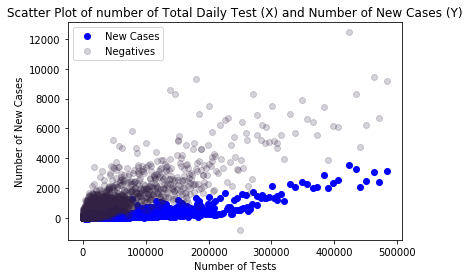

In [65]:
plt.style.use('seaborn-muted')
plt.plot(mod_df['TOTAL_TESTED'],mod_df['NEW_CASES'],'bo', label='New Cases')
plt.plot(mod_df['TOTAL_TESTED'],mod_df['NEW_NEGATIVES'], color='#332244',marker='o', linestyle='' , label= 'Negatives', alpha=0.2)
plt.title('Scatter Plot of number of Total Daily Test (X) and Number of New Cases (Y)')
plt.xlabel('Number of Tests')
plt.ylabel('Number of New Cases')
plt.legend()
plt.show()

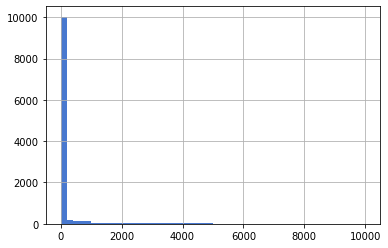

In [66]:
mod_df['NEW_CASES'].hist(bins=[0,199,200,399, 400,1000,1001,5000,5001,10000])

In [67]:
mod_df[['TOTAL_TESTED','COUNTY']].describe()

,TOTAL_TESTED
count,10634.000000
mean,11359.563758
std,32153.650075
min,1.000000
25%,288.000000
50%,1749.500000
75%,7313.500000
max,483935.000000


In [68]:
mod_df.COUNTY.nunique()

69

### Verifying that the shift worked correctly

In [69]:
mod_df[['NEGATIVE']].sum().to_frame()

,0
NEGATIVE,110825908.0


In [70]:
mod_df[['NEW_CASES']].sum().to_frame()

,0
NEW_CASES,337408.0


In [71]:
mod_df.columns

Index(['COUNTY', 'AWAITING_TESTING', 'NEGATIVE', 'POSITIVE',
       'PERCENT_POSITIVE', 'TOTAL_TESTED', 'FILE_NAME', 'INCONCLUSIVE', 'DATE',
       'DAY_OF_WEEK', 'NEW_NEGATIVES', 'NEW_CASES'],
      dtype='object')

In [72]:
mod_df['NEW_CASES'].describe().to_frame()

,NEW_CASES
count,10565.000000
mean,31.936394
std,147.059788
min,-49.000000
25%,0.000000
50%,2.000000
75%,11.000000
max,3576.000000


In [73]:
mod_df.filter(items=['NEW_CASES','COUNTY'], axis=1)

,NEW_CASES,COUNTY
10,NaN,Alachua
70,3.0,Alachua
126,3.0,Alachua
184,5.0,Alachua
250,10.0,Alachua
...,...,...
10500,13.0,Washington
10568,10.0,Washington
10637,11.0,Washington
10707,8.0,Washington


## Observations where the number of new cases is less than 0

In [74]:
# Getting Counties with over 1000 cases reported in one day
high_case = mod_df[mod_df['NEW_CASES']> 1000]
high_case.sort_values(by='NEW_CASES', inplace=True, ascending =False)
print(high_case[['COUNTY', 'NEW_CASES' ,'DATE']].head(100))
top_100 = pd.DataFrame(high_case[['COUNTY', 'NEW_CASES' ,'DATE']].head(100))


             COUNTY  NEW_CASES       DATE
10307    Miami-Dade     3576.0 2020-07-12
10376    Miami-Dade     3269.0 2020-07-13
10721    Miami-Dade     3159.0 2020-07-18
10583    Miami-Dade     3108.0 2020-07-16
10031    Miami-Dade     2916.0 2020-07-08
10238    Miami-Dade     2527.0 2020-07-11
10514    Miami-Dade     2514.0 2020-07-15
10652    Miami-Dade     2442.0 2020-07-17
9755     Miami-Dade     2418.0 2020-07-04
10169    Miami-Dade     2380.0 2020-07-10
9617     Miami-Dade     2304.0 2020-07-02
9824     Miami-Dade     2282.0 2020-07-05
9341     Miami-Dade     2152.0 2020-06-28
10445    Miami-Dade     2090.0 2020-07-14
9962     Miami-Dade     2066.0 2020-07-07
9686     Miami-Dade     2046.0 2020-07-03
10100    Miami-Dade     1987.0 2020-07-09
9893     Miami-Dade     1981.0 2020-07-06
10308       Broward     1772.0 2020-07-12
9825        Broward     1664.0 2020-07-05
10170       Broward     1603.0 2020-07-10
9479     Miami-Dade     1598.0 2020-06-30
10239       Broward     1548.0 202

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy [ipykernel_launcher.py:3]


In [75]:
# County
pd.value_counts(high_case['COUNTY'].head(100)).to_frame(name="County")

,County
Miami-Dade,23
Broward,14
Orange,4
Hillsborough,1
Lee,1
Palm Beach,1


In [76]:
neg_case = mod_df[mod_df['NEW_CASES']< 0].copy()
neg_case.sort_values(by='NEW_CASES', inplace=True)
print(neg_case[['COUNTY', 'NEW_CASES' ,'DATE']].head(20))
print(neg_case[['COUNTY', 'NEW_CASES' ,'DATE']].tail(20))
neg_case.to_csv(f'{qa_path}Observation With Negative.csv' ,sep=',')

          COUNTY  NEW_CASES       DATE
9381   Highlands      -49.0 2020-06-28
3354     Alachua      -32.0 2020-04-13
2028     Broward      -27.0 2020-04-04
6205     Jackson      -25.0 2020-05-13
2217     Unknown      -20.0 2020-04-05
8963    Suwannee      -20.0 2020-06-22
9122     Calhoun      -18.0 2020-06-24
1407     Broward      -15.0 2020-03-30
10433    Calhoun      -12.0 2020-07-13
6281     Unknown      -12.0 2020-05-14
9602      Glades      -11.0 2020-07-01
9021        Clay       -8.0 2020-06-23
9331     Calhoun       -7.0 2020-06-27
5690       Duval       -7.0 2020-05-06
4861       Duval       -6.0 2020-04-24
8426     Unknown       -5.0 2020-06-15
4051        Leon       -5.0 2020-04-18
9464     Unknown       -5.0 2020-06-29
9815     Calhoun       -4.0 2020-07-04
4647     Unknown       -4.0 2020-04-22
            COUNTY  NEW_CASES       DATE
6844     Jefferson       -1.0 2020-05-22
6275       Jackson       -1.0 2020-05-14
2330  Indian River       -1.0 2020-04-06
9808        Holme

In [ ]:
pd.value_counts(neg_case.COUNTY)

Text(0, 0.5, 'Frequency of Negative Values')

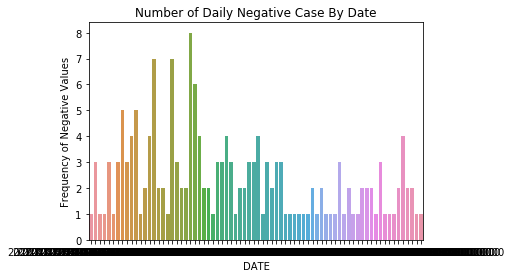

In [77]:
neg_c_freq = pd.DataFrame(neg_case.groupby('DATE')['COUNTY'].count())
neg_c_freq['COUNTY']
neg_c_freq['DATE'] = neg_c_freq.index
sns.barplot(x='DATE', y ='COUNTY',data =neg_c_freq )
plt.title('Number of Daily Negative Case By Date')
plt.ylabel('Frequency of Negative Values')

In [78]:
mod_df

,COUNTY,AWAITING_TESTING,NEGATIVE,POSITIVE,PERCENT_POSITIVE,TOTAL_TESTED,FILE_NAME,INCONCLUSIVE,DATE,DAY_OF_WEEK,NEW_NEGATIVES,NEW_CASES
10,Alachua,38.0,34.0,4.0,5.0,76.0,html version of FL COVID Rep 03-16-2020,0.0,2020-03-16,0,NaN,NaN
70,Alachua,46.0,63.0,7.0,6.0,116.0,html version of FL COVID Rep 03-18-2020,0.0,2020-03-18,2,29.0,3.0
126,Alachua,34.0,96.0,10.0,7.0,140.0,html version of FL COVID Rep 03-19-2020,0.0,2020-03-19,3,33.0,3.0
184,Alachua,50.0,273.0,15.0,5.0,338.0,html version of FL COVID Rep 03-20-2020,0.0,2020-03-20,4,177.0,5.0
250,Alachua,27.0,393.0,25.0,6.0,445.0,html version of FL COVID Rep 03-21-2020(PM),0.0,2020-03-21,5,120.0,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...
10500,Washington,3.0,2144.0,204.0,9.0,2352.0,html version of FL COVID Rep 07-14-2020,1.0,2020-07-14,1,31.0,13.0
10568,Washington,2.0,2185.0,214.0,9.0,2402.0,html version of FL COVID Rep 07-15-2020,1.0,2020-07-15,2,41.0,10.0
10637,Washington,3.0,2236.0,225.0,9.0,2465.0,html version of FL COVID Rep 07-16-2020,1.0,2020-07-16,3,51.0,11.0
10707,Washington,3.0,2391.0,233.0,9.0,2628.0,html version of FL COVID Rep 07-17-2020,1.0,2020-07-17,4,155.0,8.0


In [79]:
mod_df[mod_df['NEW_CASES']< 0].describe()

,AWAITING_TESTING,NEGATIVE,POSITIVE,PERCENT_POSITIVE,TOTAL_TESTED,INCONCLUSIVE,DAY_OF_WEEK,NEW_NEGATIVES,NEW_CASES
count,173.000000,173.000000,173.000000,173.000000,173.000000,173.000000,173.00000,173.000000,173.000000
mean,14.421965,2610.057803,153.034682,6.375723,2780.202312,2.687861,2.83815,55.774566,-2.838150
std,32.189681,3864.589752,220.554294,3.871916,4059.284854,4.578225,2.11235,122.805627,5.790664
min,0.000000,5.000000,0.000000,0.000000,7.000000,0.000000,0.00000,-7.000000,-49.000000
25%,0.000000,549.000000,29.000000,4.000000,587.000000,0.000000,1.00000,4.000000,-2.000000
50%,1.000000,1248.000000,88.000000,6.000000,1406.000000,1.000000,2.00000,15.000000,-1.000000
75%,10.000000,2644.000000,195.000000,8.000000,2803.000000,3.000000,5.00000,42.000000,-1.000000
max,223.000000,28293.000000,1765.000000,31.000000,29460.000000,22.000000,6.00000,1025.000000,-1.000000


In [80]:
# mod_df.drop('FILE_NAME1', axis = 1, inplace=True)
mod_df.columns

Index(['COUNTY', 'AWAITING_TESTING', 'NEGATIVE', 'POSITIVE',
       'PERCENT_POSITIVE', 'TOTAL_TESTED', 'FILE_NAME', 'INCONCLUSIVE', 'DATE',
       'DAY_OF_WEEK', 'NEW_NEGATIVES', 'NEW_CASES'],
      dtype='object')

# Messing around with matplotlib

In [ ]:
# plt.xkcd()
# plt.plot(mod_df['TOTAL_TESTED'],mod_df['NEW_CASES'],'bo', label='New Cases')
# plt.plot(mod_df['TOTAL_TESTED'],mod_df['NEW_NEGATIVES'], color='#332244',marker='o', linestyle='' , label= 'Negatives', alpha=0.2)
# plt.title('Scatter Plot of number of Total Daily Test (X) and Number of New Cases (Y)')
# plt.xlabel('Number of Tests')
# plt.ylabel('Number of New Cases')
# plt.legend()
# plt.savefig('plot.png')
# plt.show()

In [179]:
today.day

17